In [ ]:
%load_ext autoreload # This lets us refresh changes from other .py files without having to restart the notebook
%autoreload 2

In [1]:
import torch
from torch import nn
import torchvision as tv
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader, random_split
from icecream import ic
import numpy as np
from tqdm import tqdm # Progress bar for training
from blocks import *
from utils import showDatasetSamples, displayImageGrid, validateModelIO, TransformableSubset

from tensorboardX import SummaryWriter

from dataLoading import CIFAR10Dataset

device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
fc2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            ResidualBlock2(channelCount=16),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(in_features=144, out_features=10)
    )

validateModelIO(ResidualCNN(network=fc2, printOutsize=True))


Using device: cpu
ResidualCNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ResidualBlock2(
      (activation): ReLU()
      (c1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (c2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (residualNormalization): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
    )
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3),

### Calculate mean and stdev for normalization of dataset

In [3]:
autoAugmentCIFAR = v2.Compose([
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
])

customTransforms = v2.Compose([
    # RandomRangeCrop(),
    v2.RandomPerspective(distortion_scale=0.3, p=0.5),
    v2.RandomGrayscale(),
    v2.RandomRotation(degrees=(0, 15)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.3),
])


preNormalizationTransform = v2.Compose(
    customTransforms.transforms
)

# Create dataset instances
# fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=preNormalizationTransform)
fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=preNormalizationTransform)
TRAIN_DATASET, VALIDATION_DATSET, TEST_DATSAET = random_split(fullDataset, [0.8, 0.1, 0.1])

BATCH_SIZE = 256
trainLoader = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=False)

mean = 0.
std = 0.
for images, _ in trainLoader:
    
    batchSamples = images.size(0)
    # Get an image view of shape (batchSamples, C, H*W) which is faster than a transpose as we don't shift any data
    images = images.view(batchSamples, images.size(1), -1)
    # Calculate total mean and total std over dim=2
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

# Divide means and stdevs by number of samples
mean /= len(trainLoader.dataset)
std /= len(trainLoader.dataset)
print(mean)
print(std)


tensor([0.4147, 0.4079, 0.3802])
tensor([0.2303, 0.2270, 0.2208])


### Visualize data samples with given transform as a final sanity check

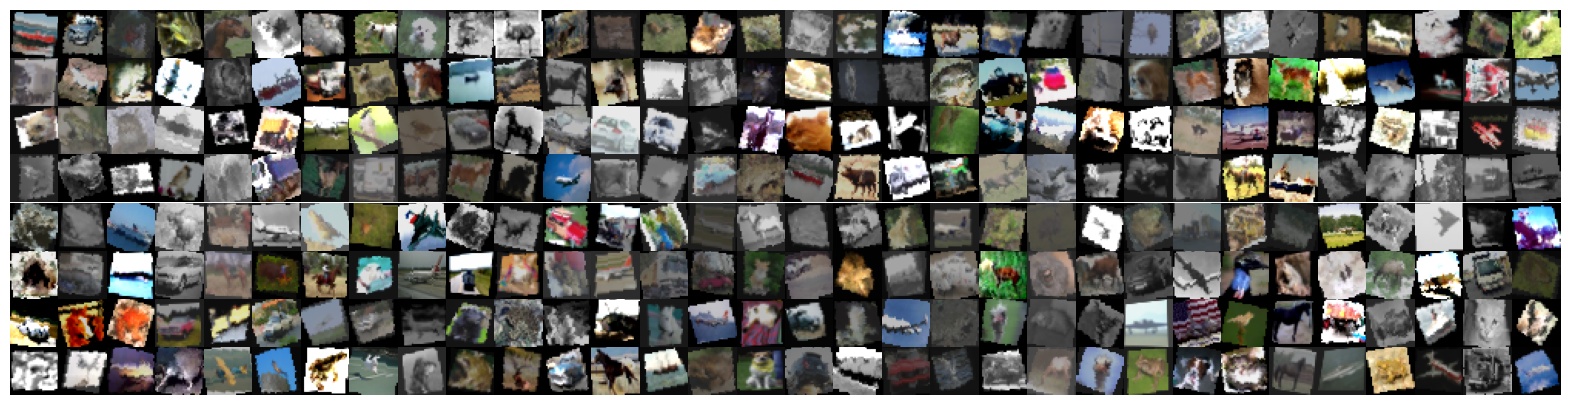

ic| features.size(): torch.Size([256, 3, 32, 32])
ic| labels.size(): torch.Size([256])


ship	automobile	horse	frog	horse	dog	deer	dog	dog	deer	bird	deer	deer	deer	cat	frog	deer	cat	ship	deer	frog	dog	ship	bird	truck	automobile	airplane	bird	horse	dog	deer	dog	
8	1	7	6	7	5	4	5	5	4	2	4	4	4	3	6	4	3	8	4	6	5	8	2	9	1	0	2	7	5	4	5	

In [4]:
def trainEpoch(model:nn.Module, dataloader:DataLoader, optimizer:torch.optim, freezeModel=False) -> tuple[float, float]:
    
    """
    Trains a given model for a single epoch when given a model, dataloader, and optimizer.
    
    Arguments:
        model: The model to be evaluated or trained
        dataloader: A dataloader for either a training, validation, or test dataset
        optimizer: The current optimizer being used during training
        freezeModel: Whether or not to freeze the model for the current epoch. We want to freeze the model when running 
            inference on validation or test datasets.

    Returns:
        (modelLoss, modelAccuracy):
            modelLoss: The average model loss across the given dataset
            modelAccuracy: The average model accuracy
    """

    
    lossFunction = nn.CrossEntropyLoss()
    
    totalLoss = 0
    
    N = 0
    correct = 0
    
    for features, labels in dataloader:
        x, y = features.to(device), labels.to(device)

        if not freezeModel:
            optimizer.zero_grad()
            
        forwardPass = model.forward(x)
        
        # This adds the current accuracy to correct which is averaged over all iterations of the epoch.
        correct += (forwardPass.argmax(dim=1) == y).float().mean().item()

        loss = lossFunction(forwardPass, y)
        totalLoss += loss.item()
        
        if not freezeModel:
            # Do gradient clipping to ensure nothing crazy is happening # TODO: Analyze gradients with and without for report
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0) # Clip gradients after calculating loss
            optimizer.step()
        
        N += 1
    
    return totalLoss / N, correct / N


visualizationTransform = v2.Compose(
    preNormalizationTransform.transforms,
)



# Create dataset instances
fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=visualizationTransform)
TRAIN_DATASET, VALIDATION_DATSET, TEST_DATSAET = random_split(fullDataset, [0.8, 0.1, 0.1])

# Set TRAIN_DATASAET to use the define training transform while the val and test datasets have the default transform
TRANSFORMABLE_TRAIN_DATASET = TransformableSubset(TRAIN_DATASET, fullDataset, transform=visualizationTransform)

BATCH_SIZE = 256
trainLoader = DataLoader(TRANSFORMABLE_TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=True)
validationLoader = DataLoader(VALIDATION_DATSET, batch_size=BATCH_SIZE, shuffle=False)

showDatasetSamples(trainLoader, fullDataset)


### Initialize actual dataset to be used

In [5]:
finalTransform = v2.Compose(
    visualizationTransform.transforms +
    # Normalize before creating the real dataset
    [v2.Normalize(mean=mean, std=std)]
)

# Create dataset instances
fullDataset = CIFAR10Dataset(rootDirectory='cifar-10', csvFilename='trainLabels.csv', dataFolder='train', transform=None)
TRAIN_DATASET, VALIDATION_DATSET, TEST_DATSAET = random_split(fullDataset, [0.8, 0.1, 0.1])

# Set TRAIN_DATASAET to use the define training transform while the val and test datasets have the default transform
TRANSFORMABLE_TRAIN_DATASET = TransformableSubset(TRAIN_DATASET, fullDataset, transform=finalTransform)

# Larger batch size usually translates to more parallelism and faster epochs overall assuming memory isn't a limiting factor
# Smaller batch size allows for more up-to-date gradient calculations, and has been said to generalize better than larger batch sizes
BATCH_SIZE = 512
# We can load data in parallel with the num_workers argument, and pin_memory allows the DataLoader to transfer the loaded data
#   directly to the GPU
trainLoader = DataLoader(TRANSFORMABLE_TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=4)
validationLoader = DataLoader(VALIDATION_DATSET, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=4)

In [6]:

torch.cuda.empty_cache()

EPOCHS = 50
RUN = '1-fc2TransformsPlateu'
RUNS_DIR = 'runs'

WARMUP_EPOCHS = 6

# TODO: Alter learning rate schedule for best performance
lr = 1e-2
gamma = 0.9
momentum = 0.8
model = ResidualCNN(network=fc2).to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=momentum)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Warmup scheduler TODO: Look at ReduceLROnPlateu
warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-9, end_factor=1, total_iters=WARMUP_EPOCHS)
mainScheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
plateuScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

schedulers = [warmup, mainScheduler]
plateuSchedulers = [warmup, plateuScheduler]

# scheduler = torch.optim.lr_scheduler.ChainedScheduler(schedulers)
scheduler = torch.optim.lr_scheduler.ChainedScheduler(plateuSchedulers)



writer = SummaryWriter(f'{RUNS_DIR}/run{RUN}_batch{BATCH_SIZE}_lr{lr:0.6f}_momentum{momentum:0.4f}', flush_secs=10)


pbar = tqdm(range(EPOCHS))

for epoch in pbar:
    trainLoss, trainAccuracy = trainEpoch(model=model, dataloader=trainLoader, optimizer=optimizer)
    validationLoss, validationAccuracy = trainEpoch(model=model, dataloader=validationLoader, optimizer=optimizer, freezeModel=True)

    if epoch < WARMUP_EPOCHS:
        currentLr = warmup.get_last_lr()[0]
    else:
        currentLr = plateuScheduler.optimizer.param_groups[0]['lr']  # Directly get LR from optimizer used in plateuScheduler

    # Write values to progress bar and save for tensorboardX
    pbar.set_description("lr: {:.6f}, trainLoss: {:.4f}, trainAccuracy: {:.4f}, validationLoss: {:.4f}, validationAccuracy: {:.4f}".format(currentLr, trainLoss, trainAccuracy, validationLoss, validationAccuracy), refresh=True)
    writer.add_scalar('trainLoss', trainLoss, epoch)
    writer.add_scalar('trainAccuracy', trainAccuracy, epoch)
    
    writer.add_scalar('validationLoss', validationLoss, epoch)
    writer.add_scalar('validationAccuracy', validationAccuracy, epoch)
    
    writer.add_scalar('lr', currentLr, epoch)

    if epoch < WARMUP_EPOCHS:
        warmup.step()
    else:
        plateuScheduler.step(validationLoss)



# pbar = tqdm(range(EPOCHS))
# for epoch in pbar:
#     train_loss, train_acc = trainEpoch(model=model, dataloader=trainLoader, optimizer=optimizer)
#     # val_loss, val_acc = self.val_epoch()
#     # self.writer.add_scalar('lr', self.lr_schedule.get_last_lr(), epoch)
#     # self.writer.add_scalar('val_acc', val_acc, epoch)
#     # self.writer.add_scalar('val_loss', val_loss, epoch)
#     # self.writer.add_scalar('train_acc', train_acc, epoch)
#     writer.add_scalar('train_loss', train_loss, epoch)
#     # pbar.set_description("val acc: {:.4f}, train acc: {:.4f}".format(val_acc, train_acc), refresh=True)
#     # if val_acc > best_val_acc:
#     #     best_val_acc = val_acc
#     #     best_epoch = epoch
#     #     torch.save(self.model.state_dict(), model_file_name)
#     # self.lr_schedule.step()
#     scheduler.step()




lr: 0.010000, trainLoss: 0.9389, trainAccuracy: 0.6653, validationLoss: 0.8632, validationAccuracy: 0.6968: 100%|██████████| 50/50 [41:44<00:00, 50.09s/it]
